# Model training: SVM

In [1]:
import pickle
import pandas as pd
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open("processed/vectors_train.pickle",'rb') as file:
    vectors_train = pickle.load(file)

with open("processed/y_train.pickle",'rb') as file:
    y_train = pickle.load(file)
    
with open("processed/vectors_test.pickle",'rb') as file:
    vectors_test = pickle.load(file)
    
with open("processed/y_test.pickle",'rb') as file:
    y_test = pickle.load(file)

Initialise a SVM and see which parameters control its behaviour.

In [3]:
svc = svm.SVC(random_state=42)
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

The first thing to do is to choose which hyperparameters to tune. We try the most common kernels, various levels of regularisation and the kernel parameters gamma (active for all but linear kernel) and degree (only for poly). Here we use a random search.

In [4]:
my_params = {
    'kernel': ('rbf', 'poly', 'linear'),
    'C': (0.0001, 0.001, 0.01),
    'gamma': (0.01, 1, 10, 100),
    'degree': tuple(range(1, 6)),
    'probability' : (True,)
}

In [5]:
%%time
clf = RandomizedSearchCV(estimator=svc,
                         param_distributions=my_params,
                         n_iter=70,
                         cv=3,
                         scoring='accuracy',
                         random_state=42,
                         verbose=1)

search = clf.fit(vectors_train, y_train)

Fitting 3 folds for each of 70 candidates, totalling 210 fits
CPU times: user 8min 50s, sys: 3.37 s, total: 8min 54s
Wall time: 9min 17s


Let's print some of the insights from the random search.

In [6]:
# best score and parameters
print(f"Best score: {search.best_score_}")
print(f"With parameters: {search.best_params_}\n")

# print combinations with high average accuracy across folds
print("Not-so-bad combos (format: Avg CV score (+/- std), parameter set):")
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search.cv_results_['params']):
    if mean > .8:
        print(f"{mean:.3f} (+/-{std:.3f}), {params}")
        
print("\nClassification report:")
target_names = ['environment', 'business', 'film', 'culture', 'education']
print(classification_report(y_test, search.predict(vectors_test), target_names=target_names))

Best score: 0.8942395814724281
With parameters: {'probability': True, 'kernel': 'poly', 'gamma': 100, 'degree': 2, 'C': 0.0001}

Not-so-bad combos (format: Avg CV score (+/- std), parameter set):
0.839 (+/-0.006), {'probability': True, 'kernel': 'poly', 'gamma': 100, 'degree': 5, 'C': 0.001}
0.887 (+/-0.007), {'probability': True, 'kernel': 'poly', 'gamma': 100, 'degree': 2, 'C': 0.01}
0.839 (+/-0.006), {'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 5, 'C': 0.0001}
0.839 (+/-0.006), {'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 5, 'C': 0.001}
0.870 (+/-0.012), {'probability': True, 'kernel': 'poly', 'gamma': 100, 'degree': 4, 'C': 0.0001}
0.887 (+/-0.007), {'probability': True, 'kernel': 'poly', 'gamma': 100, 'degree': 2, 'C': 0.001}
0.894 (+/-0.008), {'probability': True, 'kernel': 'poly', 'gamma': 100, 'degree': 2, 'C': 0.0001}

Classification report:
              precision    recall  f1-score   support

 environment       0.90      0.95      0.92   

Notice that the model scores for the "film" and "culture" classes are much lower. We can inspect further the model's predictions for these classes, to understand what is going sideways. First, though, let's extract the model version with best CV accuracy and re-train it on the whole training set.

In [7]:
# train best model
best_clf = search.best_estimator_
best_clf.fit(vectors_train, y_train)

# predict on the test set
y_pred = best_clf.predict(vectors_test)

# check accuracy on training and test
training_score = accuracy_score(y_train, best_clf.predict(vectors_train))
test_score = accuracy_score(y_test, y_pred)
print(f"Training accuracy: {training_score}")
print(f"Test accuracy: {test_score}")

Training accuracy: 0.9798327594687654
Test accuracy: 0.8938053097345132


Finally, let's print the confusion matrix, to understand when the model is struggling.

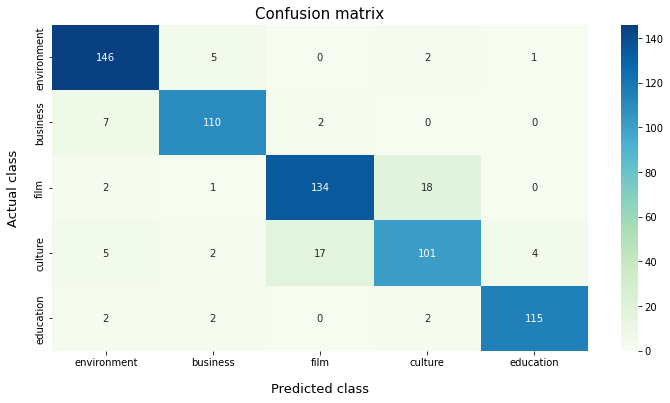

In [8]:
plt.figure(figsize=(12,6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
            xticklabels=target_names,
            yticklabels=target_names,
            annot=True,
            fmt='d',
            cmap='GnBu')
ax.set_title("Confusion matrix", fontsize=15)
ax.set_xlabel('Predicted class', labelpad=15., fontsize=13);
ax.set_ylabel('Actual class', labelpad=15., fontsize=13);

As expected, the model is most confused when dealing with articles from the "film" and "culture" sections of the Guardian. Even though we could have reasonably guessed it, the additional information we obtain explicitly from the confusion matrix is that the model mostly confuses film with culture and vice versa. This allows us to formulate the hypothesis that these two classes are very similar.

In [9]:
summary = pd.DataFrame(data=
                      {'Model name': 'SVM',
                       'Training score': training_score,
                       'Test score': test_score},
                       index=[0])
summary

,Model name,Training score,Test score
0,SVM,0.979833,0.893805


In [10]:
with open("models/best_svm.pickle", 'wb') as file:
    pickle.dump(best_clf, file)
    
with open("models/summary_svm.pickle", 'wb') as file:
    pickle.dump(summary, file)